### **Text Classification Using an RNN**

In this notebook I create a Recurrent Neural Network that will be trained to conduct sentiment analysis on the Large Movie Review Dataset (IMDB). This is a binary classification dataset where all reviews have either a positive or negative sentiment.

In [90]:
!pip3 install -q tensorflow_datasets

In [91]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [92]:
# I download the dataset from TensorFlow Datasets.
tfds.disable_progress_bar()

dataset, info = tfds.load('imdb_reviews',
                          with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [93]:
# Here are a few examples from the dataset.
for example, label in train_dataset.take(3):
  print('Text: ', example.numpy())
  print('Label: ', label.numpy())

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label:  0
Text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [94]:
# It's worth shuffling the data, and then creating batches of the 'text', 'label' pairs.
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Here are a few examples from the reshuffled dataset.
for example, label in train_dataset.take(3):
  print('Texts: ', example.numpy()[:3])
  print()
  print('Labels: ', label.numpy()[:3])

Texts:  [b'May and her husband go to visit their children and grandchildren. The visit is awkward because the grandchildren and "kids" don\'t really seem to know each other as one might expect. The warmth that should be there is missing. After dinner, May\'s husband says he doesn\'t feel well, blames it on his daughter\'s cooking, and irritably says he wants to go home. He dies that night.<br /><br />May, now a widow, is lost. She clearly did not have a passionate marriage or a very interesting one, but she had a purpose. She had someone who needed her, and even though her own needs had gone unmet for years, she had something to do with her days.<br /><br />She is depressed and unmotivated. She goes to stay with her daughter, Paula, who shortly after her mother\'s arrival, lets her mother know that she has never felt that her mother has given much of herself at all. She lets loose with anger over her mother\'s lack of nurturing. May seems disarmed and surprised, yet she also doesn\'t s

In [95]:
# The text was loaded in raw format, so it needs to be processed before I input it into the model.
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Here are the first 15 tokens in the vocabulary.
vocab = np.array(encoder.get_vocabulary())
vocab[:15]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was'], dtype='<U14')

In [96]:
# I can now encode the text into indices.
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  4, 220,   5, ...,   0,   0,   0],
       [645,   1, 390, ...,   0,   0,   0],
       [ 56, 318,   3, ...,   0,   0,   0]])

In [97]:
# Here are a few examples of the processed text.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"A comedy of epically funny proportions from the guys that brought you South Park, and most of the guys from Orgazmo. This vulgur, obscence movie has utterly disgusting, eggotistical, and satirical content. It portrays incredibly cruel treatment of humans and animals. I LOVE IT!!!!! This is some funny stuff. Really funny. Two loser friends create a game in thier driveway, which explodes into a national sensation. Corruption and greed and blackmail turn the sport sour, and its up ta Coop ta fix it. And along the way, you will laugh. Alot. That's all there is. Enjoy!!!!"
Round-trip:  a comedy of [UNK] funny [UNK] from the guys that brought you [UNK] [UNK] and most of the guys from [UNK] this [UNK] [UNK] movie has [UNK] [UNK] [UNK] and [UNK] [UNK] it [UNK] incredibly [UNK] [UNK] of [UNK] and [UNK] i love it this is some funny stuff really funny two [UNK] friends create a game in [UNK] [UNK] which [UNK] into a [UNK] [UNK] [UNK] and [UNK] and [UNK] turn the [UNK] [UNK] and its u

I now create the model, a Sequential class from Keras.

The first layer is an encoder (converts text to sequence of token indices), the second is an embedding layer (converts sequence of token indices to sequence of vectors). Then I add 2 bidirectional LSTM layers, where the output of the first LSTM layer has 3 axes, so it can be passed to another RNN layer. Finally, I apply 2 dense layers and a dropout layer.

In [98]:

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM
from keras.layers import Dense, Dropout

model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='elu'),
    Dropout(0.5),
    Dense(1)
])

In [99]:
# I configure the model for training.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
# I train the model.
history = model.fit(train_dataset,
                    validation_data=test_dataset, 
                    validation_steps=30,
                    epochs=10)

Epoch 1/10
391/391 [==============================] - 1230s 3s/step - loss: 0.6768 - accuracy: 0.5192 - val_loss: 0.4068 - val_accuracy: 0.8052
Epoch 2/10
391/391 [==============================] - 1203s 3s/step - loss: 0.3687 - accuracy: 0.8288 - val_loss: 0.3393 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 1202s 3s/step - loss: 0.3236 - accuracy: 0.8575 - val_loss: 0.3296 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 1208s 3s/step - loss: 0.3158 - accuracy: 0.8613 - val_loss: 0.3388 - val_accuracy: 0.8375
Epoch 5/10
391/391 [==============================] - 1214s 3s/step - loss: 0.3101 - accuracy: 0.8651 - val_loss: 0.3221 - val_accuracy: 0.8474
Epoch 6/10
391/391 [==============================] - 1213s 3s/step - loss: 0.3016 - accuracy: 0.8686 - val_loss: 0.3523 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 1199s 3s/step - loss: 0.3041 - accuracy: 0.8677 - val_loss: 0.3364 - val_accuracy:

In [101]:
# I verify the loss and accuracy on the test set.
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 267s 683ms/step - loss: 0.3178 - accuracy: 0.8609
Test Loss: 0.3177611529827118
Test Accuracy: 0.8608800172805786


In [102]:
# I run a prediction on a new sentence.
# If the prediction is >=0.0, it is a positive review.
# If the prediction is <0.0, it is a negative review.
sample_text = ('What a great movie! My favorite cartoon characters came to life, and I '
                    'love the soundtrack too.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[4.5822644]]


In [103]:
sample_text = ('The movie was simply bad. The plot, the sceens, the actors '
                    'were terrible. Not recommended at all.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-3.5657637]]


In [111]:
sample_text = ('I usually don`t like action movies but this one was great.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.87180996]]


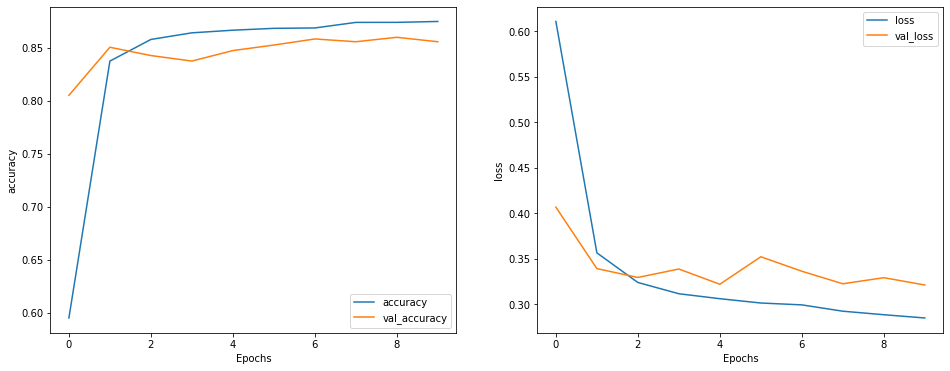

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

# I can plot the accuracy and loss metrics with Matplotlib.
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')